<a href="https://colab.research.google.com/github/eolmez91/Mushroom-Classification/blob/master/Mushroom_Roulette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Classification

## Giriş

Bu projede "UCI Machine Learning" tarafından sunulan, mantar sınıflanamasını inceleyeceğim. Bu veri kümesinin amacı, mantarları yenilebilir ve zehirli mantarlar arasında sınıflandırmaktır. İlk olarak verimizi çekip, kontrol edeceğim. Devamında da bir takım özelliklerine değinip, sınıflandırma algortimaları uygulayacağım.

## İÇİNDEKİLER

### 1.Verinin alınması ve ortamlarım kurulması

### 2.



In [85]:
# İlk olarak veri kümesinin bulunduğu drive hesabını colab'e bağlıyoruz.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# Kullanacağımız kütüphaneleri çağırıyoruz. Not: Şu an kullanılmayan kütüphaneler de çağrılmış durumda. Bunun sebebi bir takım şeyler deneyip düzgün çalıştıramadığım için.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost
from sklearn.neighbors import KNeighborsClassifier
import graphviz

import warnings
warnings.filterwarnings("ignore")

In [87]:
# Veri kümesinin bulunduğu klasöre gidiyoruz
%cd "/content/drive/My Drive/BOOTCAMP/Mushroom Classification"

/content/drive/My Drive/BOOTCAMP/Mushroom Classification


In [0]:
# Klasördeki dosyaları kontrol ediyoruz
!ls

'dead or alive.ipynb'   foo.png   mushrooms.csv


In [0]:
# Veri kümesini, mdata isimli değişkene atayalım
mdata = pd.read_csv('mushrooms.csv')

In [0]:
# Verimizi kontrol edelim
mdata.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [0]:
mdata.shape 

(8124, 23)

In [0]:
mdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

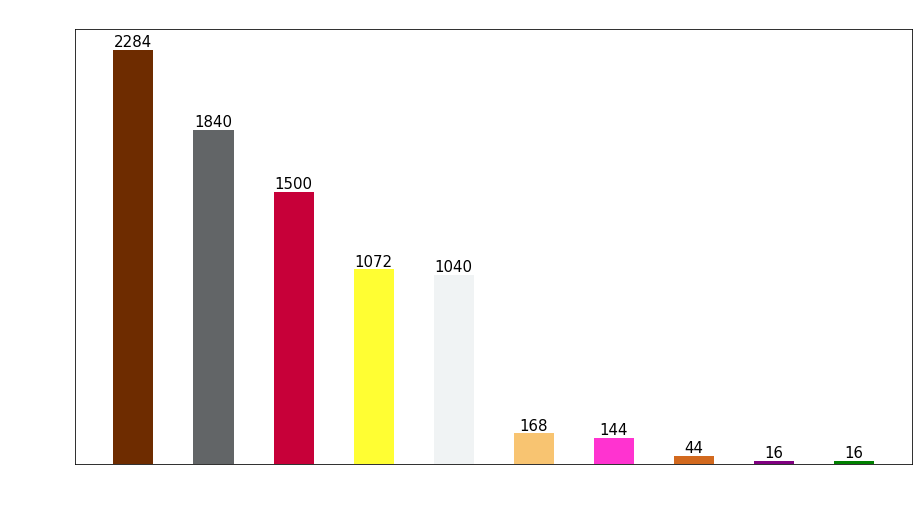

In [0]:
#Her bir renkten kaçar tane mantar olduğuna bakalım.
cap_colors = mdata['cap-color'].value_counts()
m_height = cap_colors.values.tolist() #Sayısal değerlerini gösterir
cap_colors.axes #Renk etiketlerini yazdırır
cap_color_labels = cap_colors.axes[0].tolist() #Renk dizinindekileri bir listeye atar

#Çizdirilecek grafiğin ayarlanması
ind = np.arange(10) #X ekseninin uzunluğu 
width = 0.5 #Sütünların genişliği
colors = ['#6E2C00','#626567','#C70039','#FFFE33','#F0F3F4','#F8C471','#FF33D0','#D2691E','#800080','#008000'] #Renk kodları

fig, ax = plt.subplots(figsize=(15,8))
mushroom_bars = ax.bar(ind, m_height , width, color=colors)

#Grafik üzerinde gözükecek yazıların ayarlanması
ax.set_xlabel("Cap Color",fontsize=20, color='w')
ax.set_ylabel('Quantity',fontsize=20, color='w')
ax.set_title('Mushroom Cap Color Quantity',fontsize=22, color='w')
ax.set_xticks(ind) 
ax.set_xticklabels(('brown', 'gray','red','yellow','white','buff','pink','cinnamon','purple','green'))
ax.tick_params(axis='both', labelsize=15, colors='w')

#Her sütun rengi için mantar sayısını ekleme
def autolabel(rects,fontsize=15):
    
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),
                ha='center', va='bottom',fontsize=fontsize)
autolabel(mushroom_bars)

plt.show()

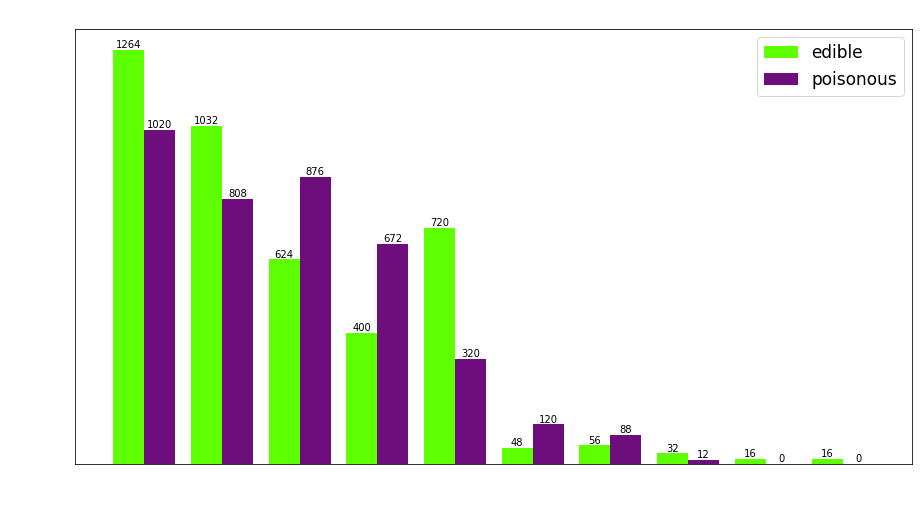

In [0]:
#Her bir renkte ne kadar zehirli ne kadar yenilebilir mantar olduğuna bakalım
edible_cc = []    #Yenilebilirler şapka rengi
poisonous_cc = [] #Zehirliler şapka rengi 
#Oluşturduğumuz listelere renklere göre ayırarak atayalım
for capColor in cap_color_labels:
    size = len(mdata[mdata['cap-color'] == capColor].index)
    edibles = len(mdata[(mdata['cap-color'] == capColor) & (mdata['class'] == 'e')].index)
    edible_cc.append(edibles)
    poisonous_cc.append(size-edibles)
                        
#Çizdirelicek grafiğin ayarlanması
width = 0.40
fig, ax = plt.subplots(figsize=(15,8))
edible_bars = ax.bar(ind, edible_cc , width, color='#5EFF00')
poison_bars = ax.bar(ind+width, poisonous_cc , width, color='#6E0E7D')

#Grafik üzerinde fontun ayarlanması
ax.set_xlabel("Cap Color",fontsize=20, color='w')
ax.set_ylabel('Quantity',fontsize=20, color='w')
ax.set_title('Edible and Poisonous Mushrooms Based on Cap Color',fontsize=22, color='w')
ax.set_xticks(ind + width / 2) #X ekseni üzerinde konumlandırma
ax.set_xticklabels(('brown', 'gray','red','yellow','white','buff','pink','cinnamon','purple','green'))
ax.tick_params(axis='both', labelsize=15, colors='w')

ax.legend((edible_bars,poison_bars),('edible','poisonous'),fontsize=17) #Yenilebilir ve zehirli olanları rengini belirtme
autolabel(edible_bars, 10)
autolabel(poison_bars, 10)
plt.show()

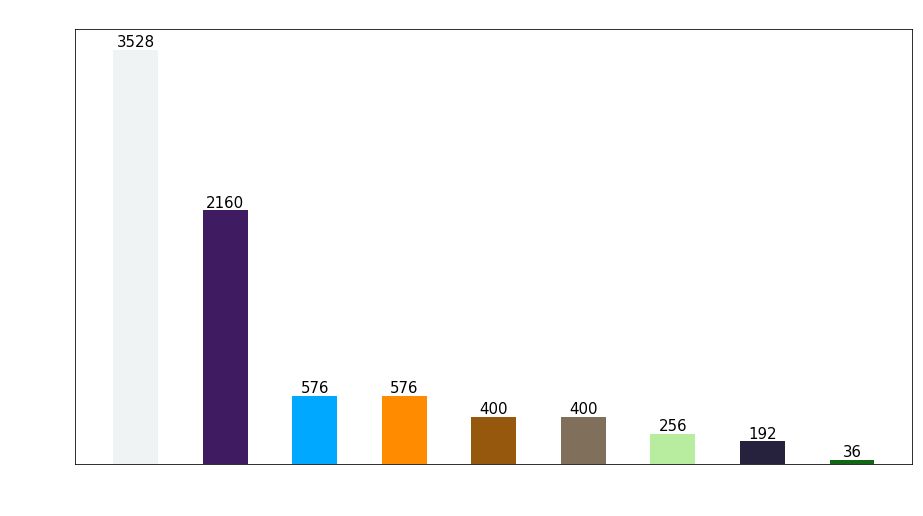

In [0]:
#Şapka rengi için yaptığımız şekilde burada da aynılarını yapıyoruz
odors = mdata['odor'].value_counts()
odor_height = odors.values.tolist() 
odor_labels = odors.axes[0].tolist()


width = 0.5 
ind = np.arange(9)  
colors = ['#F0F3F4','#3F1B61','#00A8FF','#FF8B00','#96580C','#806F5A','#B8ED9F','#26213C','#126714']

fig, ax = plt.subplots(figsize=(15,8))
odor_bars = ax.bar(ind, odor_height , width, color=colors)

#Fontun ayarlanması
ax.set_xlabel("Odor",fontsize=20, color='w')
ax.set_ylabel('Quantity',fontsize=20, color='w')
ax.set_title('Mushroom Odor and Quantity',fontsize=22, color='w')
ax.set_xticks(ind) 
ax.set_xticklabels(('none', 'foul','fishy','spicy','almond','anise','pungent','creosote','musty'))
ax.tick_params(axis='both', labelsize='15', colors='w')

autolabel(odor_bars)        
plt.show() 

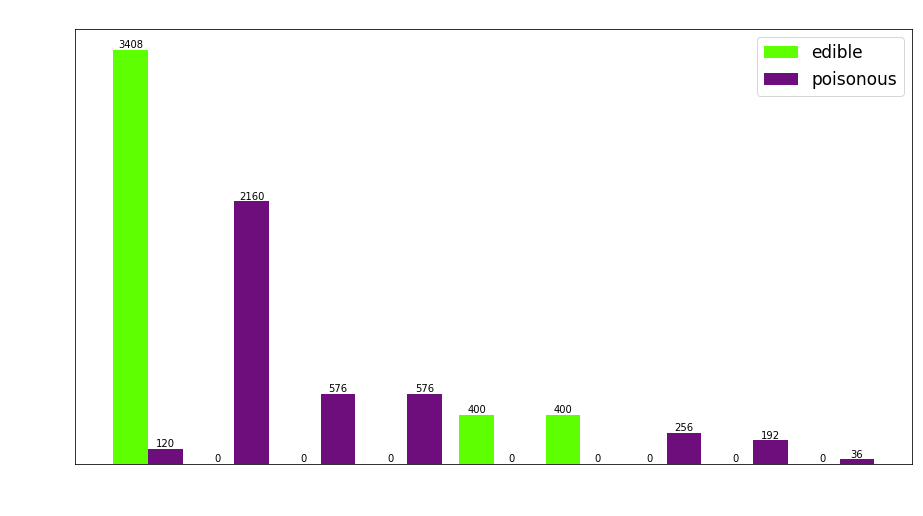

In [0]:
edible_od = []    #Yenilebilir koku listesi
poisonous_od = [] #Zehirli koku listesi
for odor in odor_labels:
    size = len(mdata[mdata['odor'] == odor].index)
    edibles = len(mdata[(mdata['odor'] == odor) & (mdata['class'] == 'e')].index)
    edible_od.append(edibles)
    poisonous_od.append(size-edibles)
                        
#Grafiğin ayarlanması
width = 0.40
fig, ax = plt.subplots(figsize=(15,8))
edible_bars = ax.bar(ind, edible_od , width, color='#5EFF00')
poison_bars = ax.bar(ind+width, poisonous_od , width, color='#6E0E7D')

#Yazıların ayarlanması
ax.set_xlabel("Odor",fontsize=20, color='w')
ax.set_ylabel('Quantity',fontsize=20, color='w')
ax.set_title('Edible and Poisonous Mushrooms Based on Odor',fontsize=22, color='w')
ax.set_xticks(ind + width / 2) 
ax.set_xticklabels(('none', 'foul','fishy','spicy','almond','anise','pungent','creosote','musty'))
ax.legend((edible_bars,poison_bars),('edible','poisonous'),fontsize=17)
ax.tick_params(axis='both', labelsize=15, colors='w')
autolabel(edible_bars, 10)
autolabel(poison_bars, 10)
plt.show()

In [0]:
# Verimize ön inceleme yaptığımıza göre artık modellemeye geçebiliriz.
labelencoder=LabelEncoder()
for column in mdata.columns:
    mdata[column] = labelencoder.fit_transform(mdata[column])

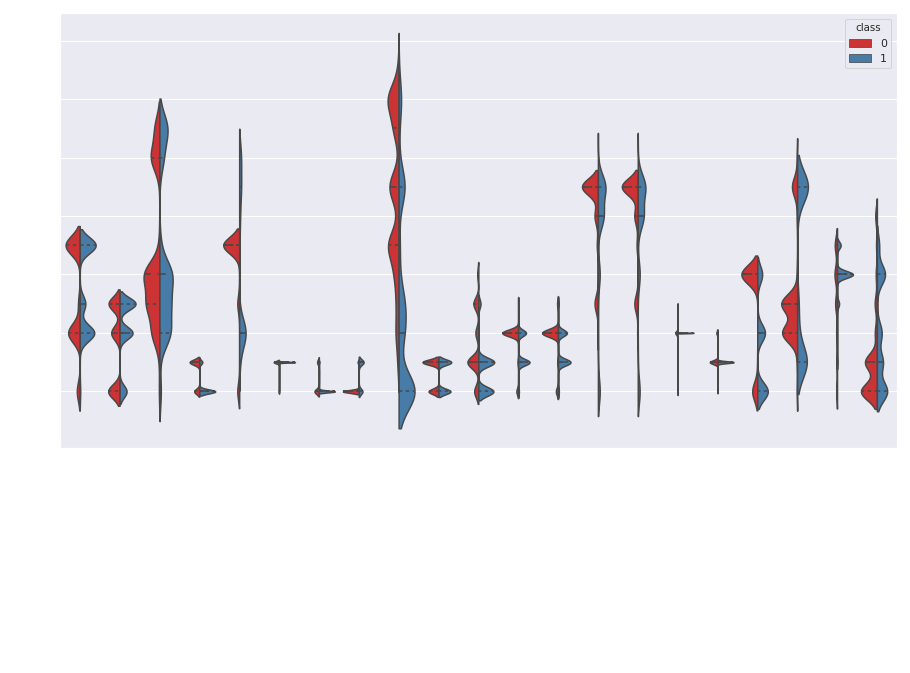

In [95]:
# Verimizde en öneplana
mdata_div = pd.melt(mdata, "class", var_name="Characteristics")
fig, ax = plt.subplots(figsize=(15,8))
p = sns.violinplot(ax = ax, x="Characteristics", y="value", hue="class", split = True, data=mdata_div, inner = 'quartile', palette = 'Set1')
ax.tick_params(axis='both', labelsize=15, colors='w')
ax.set_xlabel('Characteristics', fontsize='22', color='w')
ax.set_ylabel('Values', fontsize=22, color='w')
mdata_no_class = mdata.drop(["class"],axis = 1)
p.set_xticklabels(rotation = 90, labels = list(mdata_no_class.columns))
plt.show()

#Grafiğimizi çizdirdikten sonra en öne çıkan 

In [0]:
mdata.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.0,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000
mean,0.482029,3.348104,1.827671,4.504677,0.415559,4.144756,0.974151,0.161497,0.309207,4.810684,0.567208,1.109798,1.575086,1.603644,5.816347,5.794682,0.0,1.965534,1.069424,2.291974,3.596750,3.644018,1.508616
std,0.499708,1.604329,1.229873,2.545821,0.492848,2.103729,0.158695,0.368011,0.462195,3.540359,0.495493,1.061106,0.621459,0.675974,1.901747,1.907291,0.0,0.242669,0.271064,1.801672,2.382663,1.252082,1.719975
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,3.000000,0.000000,2.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,6.000000,6.000000,0.0,2.000000,1.000000,0.000000,2.000000,3.000000,0.000000
50%,0.000000,3.000000,2.000000,4.000000,0.000000,5.000000,1.000000,0.000000,0.000000,5.000000,1.000000,1.000000,2.000000,2.000000,7.000000,7.000000,0.0,2.000000,1.000000,2.000000,3.000000,4.000000,1.000000
75%,1.000000,5.000000,3.000000,8.000000,1.000000,5.000000,1.000000,0.000000,1.000000,7.000000,1.000000,1.000000,2.000000,2.000000,7.000000,7.000000,0.0,2.000000,1.000000,4.000000,7.000000,4.000000,2.000000
max,1.000000,5.000000,3.000000,9.000000,1.000000,8.000000,1.000000,1.000000,1.000000,11.000000,1.000000,4.000000,3.000000,3.000000,8.000000,8.000000,0.0,3.000000,2.000000,4.000000,8.000000,5.000000,6.000000


In [0]:
#Yukarıda görüldüğü üzere 'stalk-root' eksik bir dereğere sahip '?' ve 'veil-type' ise sadece tek bir değer içeriyor. Bunu kullanmak gereksiz olduğundan kaldıralım.
mdata = mdata.drop('veil-type', axis=1)

In [92]:
#info üzerinde görülüyor fakat eksik değer olup olmadığına bakalım
mdata.isnull().sum().sum()

0

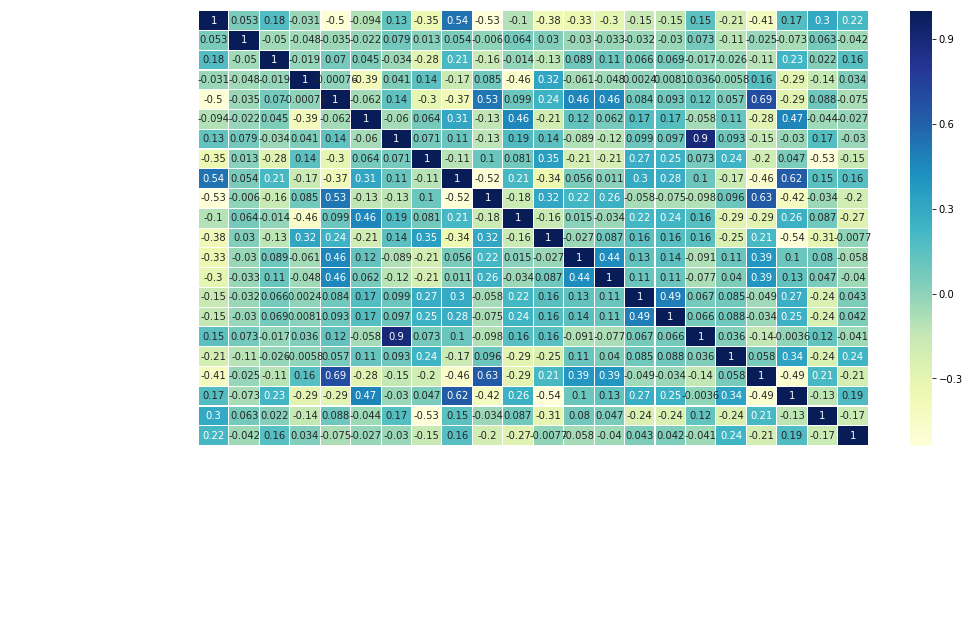

In [0]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(mdata.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
ax.tick_params(axis='both', labelsize=15, colors='w')
plt.yticks(rotation=0)
plt.show()

In [0]:
# Şimdi test ve train datalarımızı oluşturuyoruz
X = mdata.drop(['class'], axis=1)
y = mdata['class']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 28)

In [98]:
model_names = ["Decision Tree", "Random Forest", "Logistic Regression", "XGBOOST", "GaussianNB", "Nearest Neighbors"]
models = [DecisionTreeClassifier(max_depth=5),
         RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
         LogisticRegression(),
         XGBClassifier(),
         GaussianNB(),
         KNeighborsClassifier(3)]

acc =[]

for i, model in enumerate(models):
    model.fit(X_train, y_train)
    acc.append(accuracy_score(y_test, model.predict(X_test))*100)
    print ( model_names[i] + ' doğruluğu: %.2f%%' % (accuracy_score(y_test, model.predict(X_test))*100))
    

Decision Tree doğruluğu: 97.87%
Random Forest doğruluğu: 95.73%
Logistic Regression doğruluğu: 94.71%
XGBOOST doğruluğu: 99.79%
GaussianNB doğruluğu: 92.21%
Nearest Neighbors doğruluğu: 99.79%


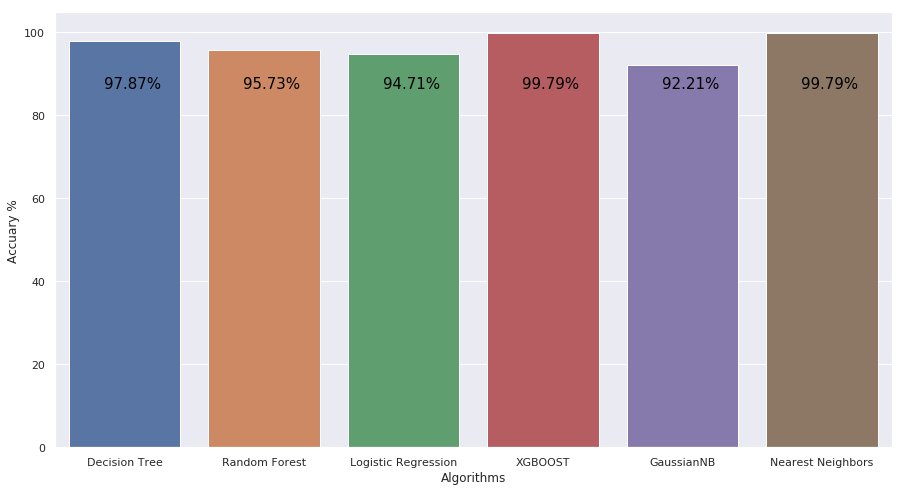

In [0]:
d={'Model':model_names,'Score':acc}
acc_frame=pd.DataFrame(d)
acc_frame.sort_values(by='Score', ascending=False)

sns.set()
plt.figure(figsize=(15,8))
plt.ylabel("Accuary %")
plt.xlabel("Algorithms")
sns.barplot(x=model_names, y=acc, palette="deep")

# Kırılımlar Üzerine Değerlerini Yazmak
for line in range(len(model_names)):
     plt.text(line-0.15, # x
              85.70, # y
             "{:.2f}%".format(acc[line]),
             horizontalalignment='left',
             verticalalignment='bottom',
              size='large',
             color="black",
             fontsize = 15
             )
        
plt.show()

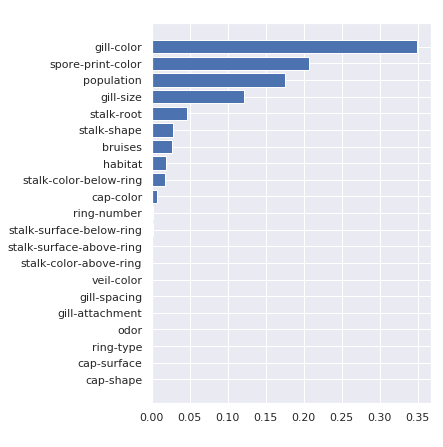

In [109]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

features_list = X.columns.values
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(5,7))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance', color='w')
plt.title('Feature importances', color='w')
ax.tick_params(axis='both', labelsize=15, colors='w')
plt.draw()
plt.show()